# Oblique Video Transformation

This notebook demonstrates how to perform coordinate transformation for oblique (side-view) river videos using RIVeR. Unlike nadir views, oblique videos require a more complex homography transformation to account for perspective distortion.

## Prerequisites

- Completed frame extraction (00_introduction.ipynb) 
- GRP measurements from field survey including known distances between points
- An oblique view frame to work with
- 4 points with known real-world distances 

## Theory

Oblique transformation requires:
- More GRPs than nadir view (4)
- Known distances between points
- Careful point selection across the frame to capture perspective

In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

# Import RIVeR modules using relative imports
from river.core.coordinate_transform import (
    oblique_view_transformation_matrix,
    transform_pixel_to_real_world,
    transform_real_world_to_pixel
)

# Set up paths 
frame_path = Path("data/frames/pisco/0000000004.jpg")
output_dir = Path("results/pisco")
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Load and Display the Frame

First, we'll load our sample frame and prepare it for transformation. For oblique views, it's important to select a frame where all GRPs are clearly visible.

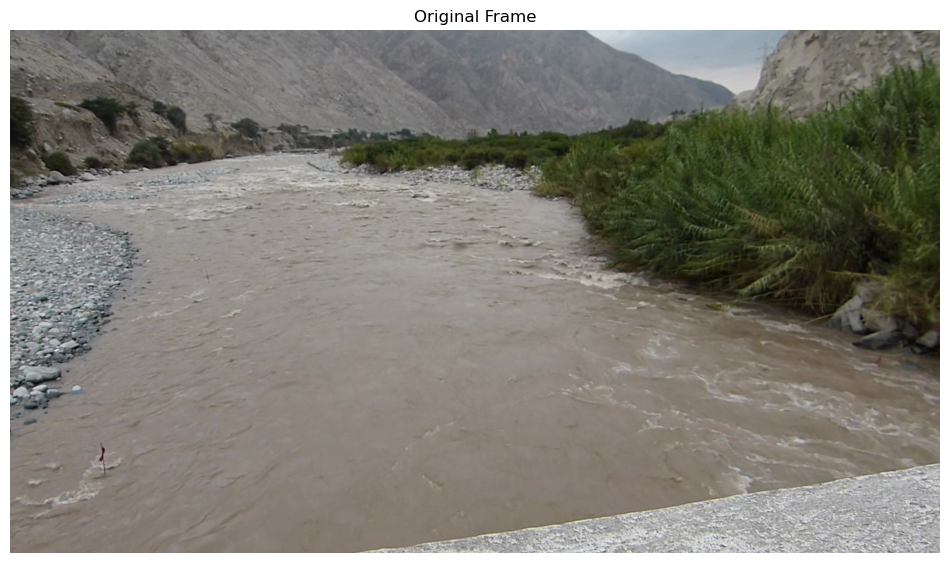

In [11]:
# Load the image
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the frame
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('Original Frame')
plt.show()

## Step 2: Define Ground Control Points (GRPs)

For oblique transformation, we need 4 points with known distances between them. The points should be:
- Well distributed across the frame
- Include points at different depths in the scene
- Have accurately measured distances between them

Point ordering is critical for correct transformation:
- Point 1 must be the most upstream and leftmost point in your view
- Remaining points (2, 3, and 4) must be defined in counterclockwise order
- Example ordering:
  * Point 1: Upstream-left
  * Point 2: Upstream-right
  * Point 3: Downstream-right
  * Point 4: Downstream-left

This specific ordering ensures proper calculation of the homography transformation and accurate real-world coordinate mapping.

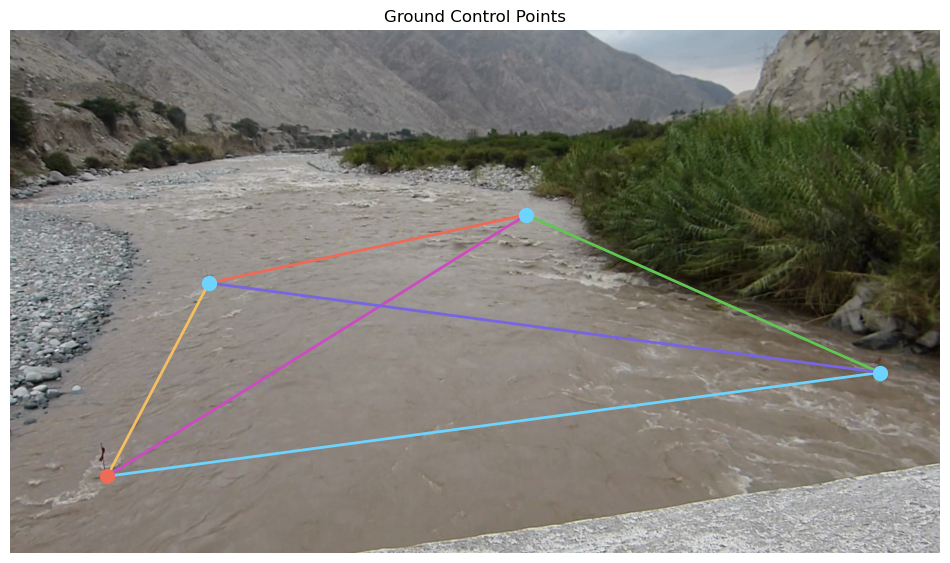

In [12]:
# Example GRP coordinates (replace with your actual measurements)
# Format: pixel coordinates (x, y) for 4 points forming a quadrilateral
point_coords_pixel = {
    'point1': (200.24, 921.03),   # left-upstream
    'point2': (1795.28, 706.98),  # right-upstream
    'point3': (1065.19, 381.29), # left-downstream
    'point4': (409.99, 521.95)   # left-downstream
}

# Known distances between points in meters
distances = {
    'd12': 19.97,  # Distance between points 1 and 2
    'd23': 36.84,   # Distance between points 2 and 3
    'd34': 29.3,  # Distance between points 3 and 4
    'd41': 19.73,   # Distance between points 4 and 1
    'd13': 44.36,  # Diagonal distance between points 1 and 3
    'd24': 27.14   # Diagonal distance between points 2 and 4
}

# Extract coordinates for transformation
x1_pix, y1_pix = point_coords_pixel['point1']
x2_pix, y2_pix = point_coords_pixel['point2']
x3_pix, y3_pix = point_coords_pixel['point3']
x4_pix, y4_pix = point_coords_pixel['point4']

# Calculate transformation matrix
transformation_matrix = oblique_view_transformation_matrix(
    x1_pix, y1_pix,
    x2_pix, y2_pix,
    x3_pix, y3_pix,
    x4_pix, y4_pix,
    distances['d12'],
    distances['d23'],
    distances['d34'],
    distances['d41'],
    distances['d13'],
    distances['d24']
)

# Visualize the points on the frame
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

# Draw lines with specific colors
# Line 1-2
plt.plot([x1_pix, x2_pix], [y1_pix, y2_pix], color='#6CD4FF', linewidth=2)
# Line 2-3
plt.plot([x2_pix, x3_pix], [y2_pix, y3_pix], color='#62C655', linewidth=2)
# Line 3-4
plt.plot([x3_pix, x4_pix], [y3_pix, y4_pix], color='#ED6B57', linewidth=2)
# Line 4-1
plt.plot([x4_pix, x1_pix], [y4_pix, y1_pix], color='#F5BF61', linewidth=2)
# Diagonal 1-3
plt.plot([x1_pix, x3_pix], [y1_pix, y3_pix], color='#CC4BC2', linewidth=2)
# Diagonal 2-4
plt.plot([x2_pix, x4_pix], [y2_pix, y4_pix], color='#7765E3', linewidth=2)

# Plot points
# Point 1 in red
plt.plot(x1_pix, y1_pix, 'o', color='#ED6B57', markersize=10)
# Points 2-4 in blue
plt.plot([x2_pix, x3_pix, x4_pix], [y2_pix, y3_pix, y4_pix], 'o', color='#6CD4FF', markersize=10)

plt.axis('off')
plt.title('Ground Control Points')
plt.show()

## Step 3: Save Transformation Matrix

We'll save the transformation matrix to a JSON file for use in subsequent processing steps.

In [15]:
# Save transformation matrix to JSON
output_file = output_dir / "transformation.json"
with open(output_file, 'w') as f:
    json.dump(transformation_matrix.tolist(), f, indent=1)
print(f"Transformation matrix saved to {output_file}")

# Verify transformation by converting some test points
test_pixel = (800, 900)  # Example pixel coordinates
real_world = transform_pixel_to_real_world(test_pixel[0], test_pixel[1], transformation_matrix)
print("\nTransformation Test:")
print(f"Pixel coordinates: {test_pixel}")
print(f"Real-world coordinates (meters): ({real_world[0]:.2f}, {real_world[1]:.2f})")

Transformation matrix saved to results/pisco/transformation.json

Transformation Test:
Pixel coordinates: (800, 900)
Real-world coordinates (meters): (6.09, -1.36)


## Common Issues and Troubleshooting

1. Poor Transformation Results:
   - Ensure GRP measurements are accurate
   - Distribute points evenly across the frame
   - Avoid colinear points

2. Transformation Matrix Errors:
   - Check for typos in coordinates
   - Verify distance measurements
   - Ensure points form a proper quadrilateral

3. Perspective Issues:
   - Include points at different depths in the scene
   - Use points that bound the area of interest
   - Consider lens distortion effects

## Next Steps

After successful transformation:
- Proceed to PIV analysis (03_cross_sections.ipynb)
- Use transformation matrix for velocity calculations
- Convert results back to real-world coordinates